In [231]:
import requests
import pandas as pd
from time import sleep
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from prophet import Prophet

import pandas as pd
import requests
import json
import os
from dotenv import load_dotenv
# from urllib.request import urlopen
import plotly 

# Specify the file path to save the compressed CSV
csv_file_path = 'historical_crime.csv.gz'



In [232]:
load_dotenv()

token = os.getenv("TOKEN")
# Define the base URL for the API
base_url = "https://data.cityofnewyork.us/resource/8h9b-rp9u.json"

# Define headers including the app token
headers = {
    'X-App-Token': token
}

# Function to handle pagination, fetch all data, and implement a delay between requests
def fetch_all_data(base_url, headers):
    limit = 50000  # Adjust the limit as needed, depending on what the API allows
    offset = 0
    full_data = []

    while True:
        # Construct the query with pagination and date filtering
        query_url = f"{base_url}?$limit={limit}&$offset={offset}" \
                    f"&$where=ARREST_DATE between '2014-01-01T00:00:00.000' and '2023-12-31T23:59:59.999'"
        
        response = requests.get(query_url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch data: HTTP Status Code {response.status_code}")
            break
        
        data = response.json()
        if not data:
            break  # Break the loop if no more data is returned
        
        full_data.extend(data)
        offset += limit
        
        # Sleep for 5 seconds before making the next request
        sleep(5)
    
    return full_data

# Fetch all data using the defined function
all_data = fetch_all_data(base_url, headers)

# Create a DataFrame from the fetched data
try:
    historical_df = pd.DataFrame(all_data)
except: 
    print("Something went wrong")

# Display the first few rows of the DataFrame to verify it
print(historical_df.head())
print(f"Total rows fetched: {len(historical_df)}")

  arrest_key              arrest_date pd_cd                          pd_desc  \
0   94273780  2014-01-01T00:00:00.000   397  ROBBERY,UNCLASSIFIED,OPEN AREAS   
1   94272165  2014-01-01T00:00:00.000   205             TRESPASS 2, CRIMINAL   
2   94273806  2014-01-01T00:00:00.000   750                 RESISTING ARREST   
3   94272052  2014-01-01T00:00:00.000   109         ASSAULT 2,1,UNCLASSIFIED   
4   94259980  2014-01-01T00:00:00.000   101                        ASSAULT 3   

  ky_cd                               ofns_desc    law_code law_cat_cd  \
0   105                                 ROBBERY  PL 1601001          F   
1   352                       CRIMINAL TRESPASS  PL 1401500          M   
2   359  OFFENSES AGAINST PUBLIC ADMINISTRATION  PL 2053000          M   
3   106                          FELONY ASSAULT  PL 1200501          F   
4   344            ASSAULT 3 & RELATED OFFENSES  PL 1200001          M   

  arrest_boro arrest_precinct jurisdiction_code age_group perp_sex  \
0   

In [233]:
# Remove unwanted columns
historical_df.dropna(axis=1)
historical_df.drop(columns=['pd_cd', 'arrest_key','law_cat_cd','law_code','pd_desc','x_coord_cd', 'y_coord_cd', 'ky_cd','arrest_precinct','jurisdiction_code' ], inplace=True)

In [234]:
# Rename Columns
new_column_names = {
    'arrest_date': 'Arrest date',
    'ofns_desc': 'Offense description',
    'arrest_boro': 'Arrest boro',
    'age_group': 'Age group',
    'perp_sex': 'Sex',
    'perp_race': 'Race',
    'latitude': 'Latitude',
    'longitude': 'Longitude'
}
historical_df.rename(columns=new_column_names,inplace=True)

In [235]:
# Write the DataFrame to a GZIP-compressed CSV file
historical_df.to_csv(csv_file_path, index=False, compression='gzip')
print(historical_df.shape[0])

2502242


In [236]:
# Read a compressed CSV file (e.g., gzip-compressed)
historical_df = pd.read_csv(csv_file_path, compression='gzip')

In [237]:
historical_df.head()

Arrest date                     Offense description  \
0  2014-01-01T00:00:00.000                                 ROBBERY   
1  2014-01-01T00:00:00.000                       CRIMINAL TRESPASS   
2  2014-01-01T00:00:00.000  OFFENSES AGAINST PUBLIC ADMINISTRATION   
3  2014-01-01T00:00:00.000                          FELONY ASSAULT   
4  2014-01-01T00:00:00.000            ASSAULT 3 & RELATED OFFENSES   

  Arrest boro Age group Sex            Race   Latitude  Longitude  \
0           B       <18   M           BLACK  40.835733 -73.921285   
1           M     25-44   M           BLACK  40.814787 -73.957502   
2           K     25-44   M           BLACK  40.575992 -73.990606   
3           B     25-44   F           WHITE  40.818079 -73.896938   
4           B     25-44   M  WHITE HISPANIC  40.837001 -73.903706   

                                             lon_lat  
0  {'type': 'Point', 'coordinates': [-73.92128542...  
1  {'type': 'Point', 'coordinates': [-73.95750196...  
2  {'type': 'Point', 'coordinates': [-73.99060607...  
3  {'type': 'Point', 'coordinates': [-73.89693760...  
4  {'type': 'Point', 'coordinates': [-73.90370600...

In [239]:
historical_df.dtypes

Arrest date             object
Offense description     object
Arrest boro             object
Age group               object
Sex                     object
Race                    object
Latitude               float64
Longitude              float64
lon_lat                 object
dtype: object

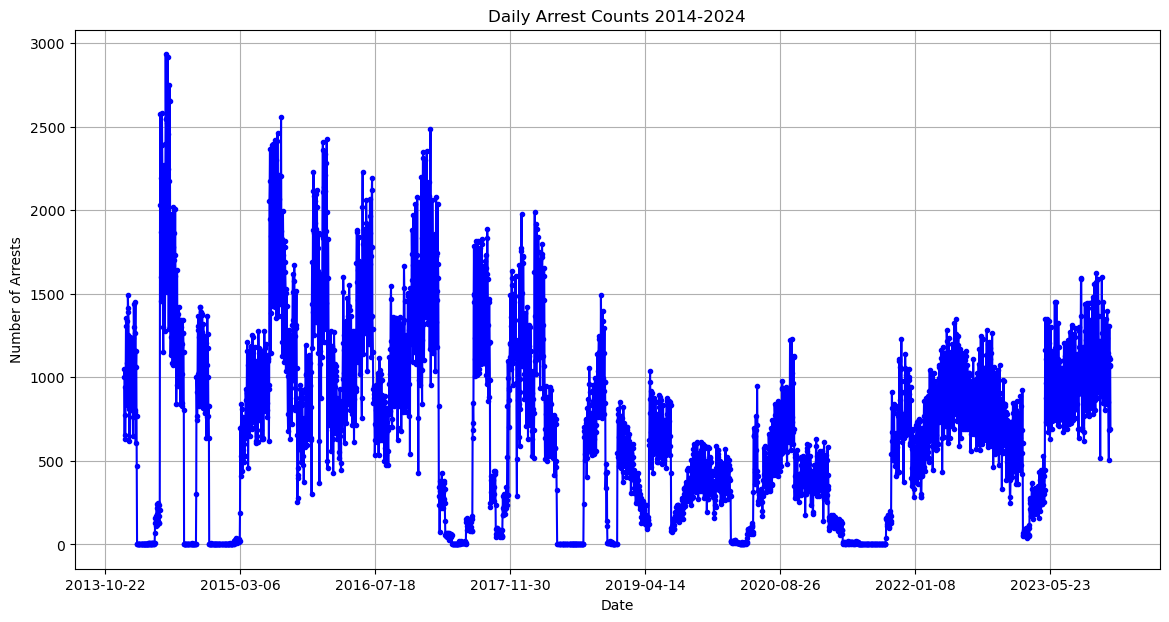

In [240]:
historical_df['Arrest date'] = pd.to_datetime(historical_df['Arrest date']).dt.date
arrest_counts = historical_df.groupby('Arrest date').size()

plt.figure(figsize=(14, 7))  
arrest_counts.plot(kind='line', color='blue', marker='.', linestyle='-')  

plt.title('Daily Arrest Counts 2014-2024')  # 
plt.xlabel('Date')  
plt.ylabel('Number of Arrests')  
plt.grid(True)  

# Improve the x-axis ticks to show fewer dates for clarity
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust the number as needed

plt.show()

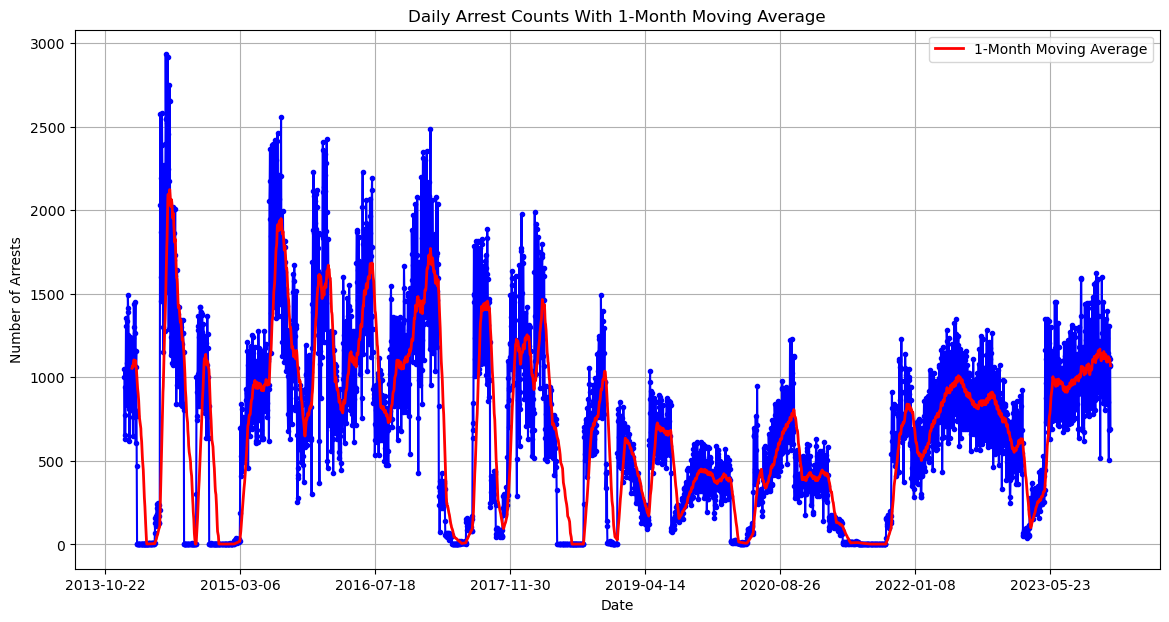

In [241]:
# Calculate the 30-day moving average of arrest counts
moving_average = arrest_counts.rolling(window=30).mean()

# Plot the moving average on top of the existing daily arrests plot
plt.figure(figsize=(14, 7))
arrest_counts.plot(kind='line', color='blue', marker='.', linestyle='-')  # Your existing daily plot
moving_average.plot(kind='line', color='red', linewidth=2, label='1-Month Moving Average')  # Moving average

plt.title('Daily Arrest Counts With 1-Month Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Arrests')
plt.legend()
plt.grid(True)

# Set major x-axis locator for clarity if there are many data points
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.show()

In [242]:
data = {
    "Year": ["2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"],
    "Bronx": [1430500, 1440000, 1443000, 1440000, 1432300, 1420000, 1461000, 1420100, 1380000, 1380000],
    "Manhattan": [1631700, 1637300, 1636700, 1632300, 1632400, 1632300, 1677300, 1578300, 1569300, 1569300],
    "Staten Island": [472000, 472300, 474200, 475800, 476500, 476100, 494600, 493500, 491100, 491100],
    "Queens": [2298234, 2305252, 2306249, 2295226, 2275286, 2253942, 2388586, 2328141, 2278029, 2278029],
    "Kings (Brooklyn)": [2601527, 2608797, 2608146, 2594357, 2580088, 2562329, 2719044, 2637486, 2590516, 2590516],
    "NYC Total": [8436961, 8450649, 8448295, 8424683, 8396874, 8343671, 8697530, 8486927, 8387845, 8387845]
}
# Convert the dictionary to a DataFrame
df_nyc_population = pd.DataFrame(data)

# Display the initial DataFrame
print(df_nyc_population)

   Year    Bronx  Manhattan  Staten Island   Queens  Kings (Brooklyn)  \
0  2014  1430500    1631700         472000  2298234           2601527   
1  2015  1440000    1637300         472300  2305252           2608797   
2  2016  1443000    1636700         474200  2306249           2608146   
3  2017  1440000    1632300         475800  2295226           2594357   
4  2018  1432300    1632400         476500  2275286           2580088   
5  2019  1420000    1632300         476100  2253942           2562329   
6  2020  1461000    1677300         494600  2388586           2719044   
7  2021  1420100    1578300         493500  2328141           2637486   
8  2022  1380000    1569300         491100  2278029           2590516   
9  2023  1380000    1569300         491100  2278029           2590516   

   NYC Total  
0    8436961  
1    8450649  
2    8448295  
3    8424683  
4    8396874  
5    8343671  
6    8697530  
7    8486927  
8    8387845  
9    8387845  


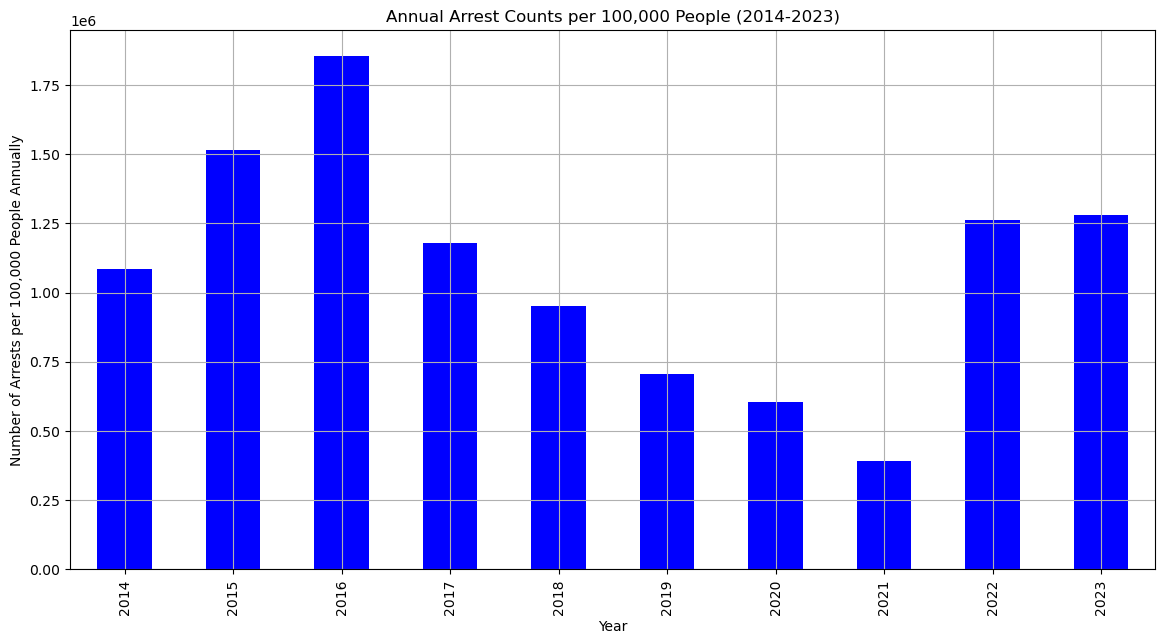

In [243]:
historical_df['Arrest date'] = pd.to_datetime(historical_df['Arrest date'])
historical_df['year'] = historical_df['Arrest date'].dt.year

# Aggregate arrests by year
annual_arrest_counts = historical_df.groupby('year').size()

# Load or ensure the population data is ready with 'Year' as an index
data = {
    "Year": [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    "NYC Total": [8436961, 8450649, 8448295, 8424683, 8396874, 8343671, 8697530, 8486927, 8387845, 8387845]
}
df_nyc_population = pd.DataFrame(data)
df_nyc_population.set_index('Year', inplace=True)  # Making sure 'Year' is the index

# Calculate arrests per 100,000 people for each year
# Multiply by 365 to normalize over the number of days in a year to get an annual rate
arrests_per_100k = (annual_arrest_counts / df_nyc_population['NYC Total']) * 100000 * 365

# Plotting the results
plt.figure(figsize=(14, 7))
arrests_per_100k.plot(kind='bar', color='blue')  # Using a bar plot for yearly data
plt.title('Annual Arrest Counts per 100,000 People (2014-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Arrests per 100,000 People Annually')
plt.grid(True)
plt.show()

20:17:55 - cmdstanpy - INFO - Chain [1] start processing
20:17:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\kidal\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\kidal\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



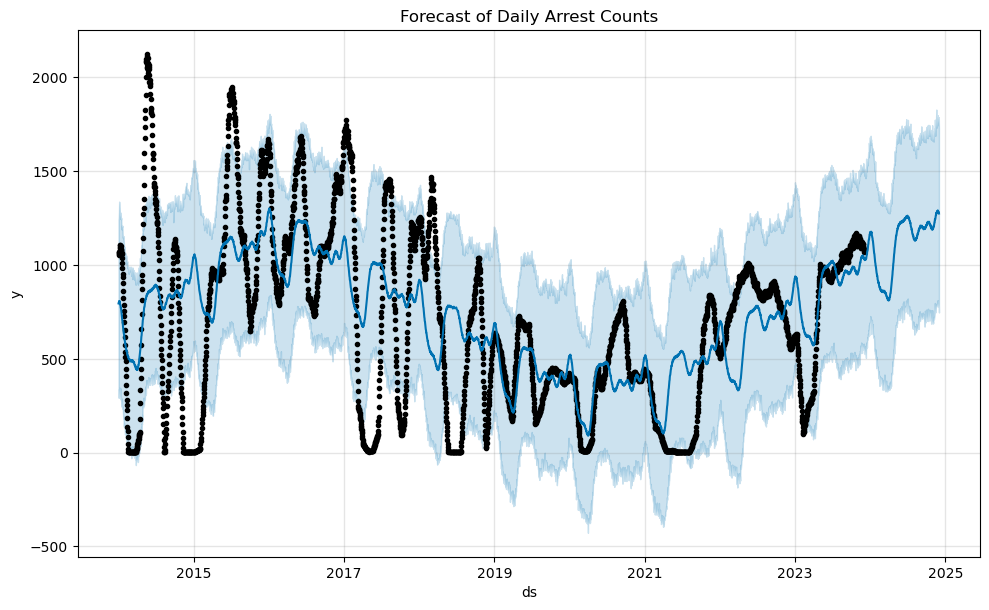

In [244]:
# Sample DataFrame creation, assuming 'historical_df' has been loaded correctly
# Check if the arrest counts are correctly summed daily, which seems likely okay from your previous description
historical_df['Arrest date'] = pd.to_datetime(historical_df['Arrest date'])
historical_df['year'] = historical_df['Arrest date'].dt.year

# Aggregating by arrest_date to ensure there are no errors
daily_arrest_counts = historical_df.groupby('Arrest date').size().reset_index(name='count')

# Calculate the 30-day moving average
daily_arrest_counts['Moving_Average'] = daily_arrest_counts['count'].rolling(window=30).mean().shift(-29)

# Drop NaNs which are generated by rolling mean at the start
daily_arrest_counts.dropna(inplace=True)

# Ensure there are enough data points
if daily_arrest_counts.shape[0] < 2:
    raise ValueError("Not enough data points to fit the model.")

# Preparing data for Prophet
df_prophet = daily_arrest_counts[['Arrest date', 'Moving_Average']]
df_prophet.columns = ['ds', 'y']  # Renaming for Prophet

# Fit the Prophet model
m = Prophet()
m.fit(df_prophet)

# Make a future dataframe for forecasting
future = m.make_future_dataframe(periods=365)

# Predict the future
forecast = m.predict(future)

# Plot the forecast
fig = m.plot(forecast)
plt.title('Forecast of Daily Arrest Counts')
plt.show()

In [245]:
historical_df['Offense description'].value_counts()

Offense description
ASSAULT 3 & RELATED OFFENSES                   327175
DANGEROUS DRUGS                                322755
PETIT LARCENY                                  216984
FELONY ASSAULT                                 164558
VEHICLE AND TRAFFIC LAWS                       142432
MISCELLANEOUS PENAL LAW                        126231
OTHER OFFENSES RELATED TO THEFT                114542
DANGEROUS WEAPONS                               99787
ROBBERY                                         98197
GRAND LARCENY                                   94379
OTHER STATE LAWS                                53433
CRIMINAL MISCHIEF & RELATED OFFENSES            52953
BURGLARY                                        52467
CRIMINAL MISCHIEF & RELATED OF                  51788
OFFENSES AGAINST PUBLIC ADMINISTRATION          47822
CRIMINAL TRESPASS                               47132
INTOXICATED & IMPAIRED DRIVING                  45507
FORGERY                                         45068
OTHER TR

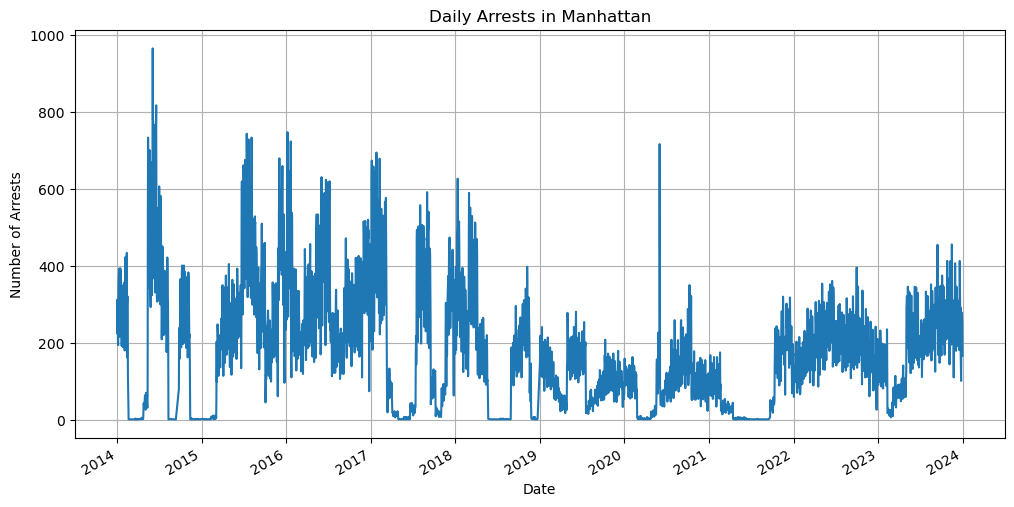

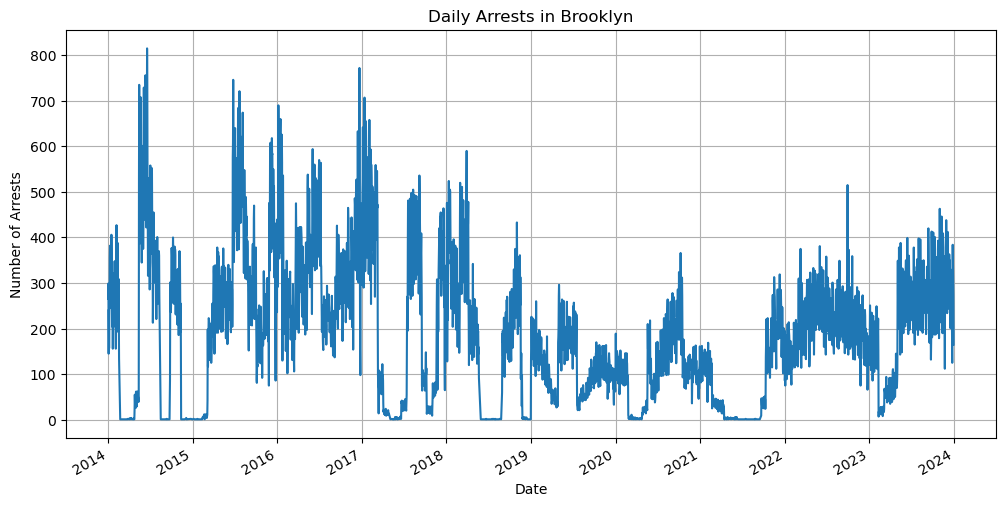

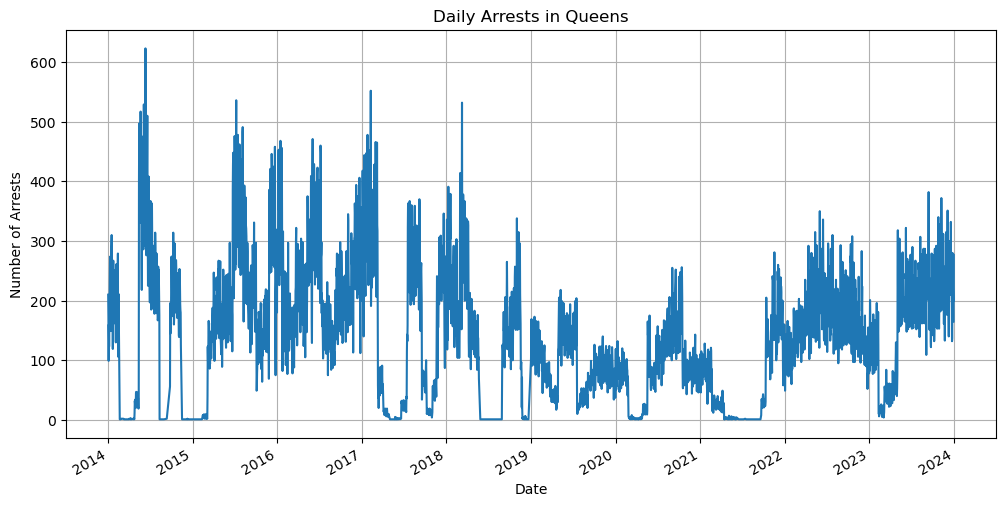

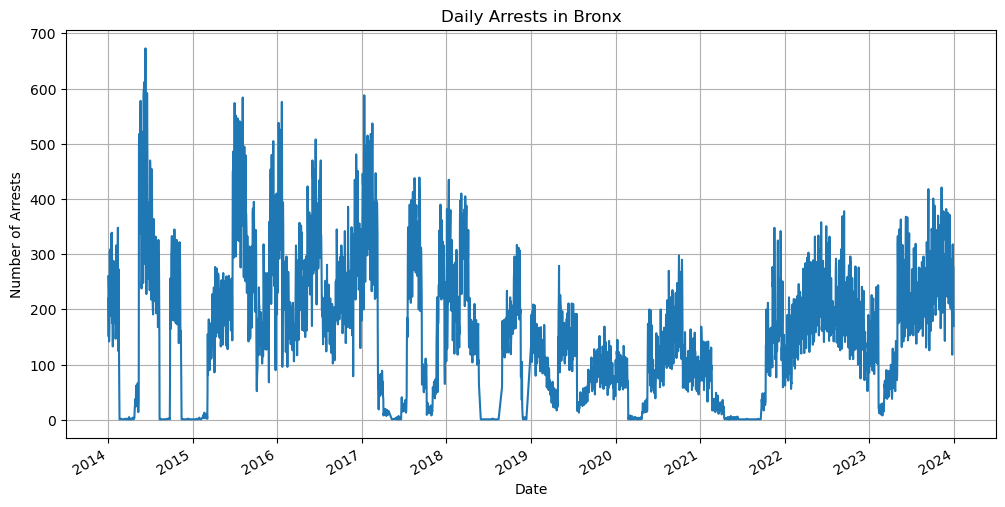

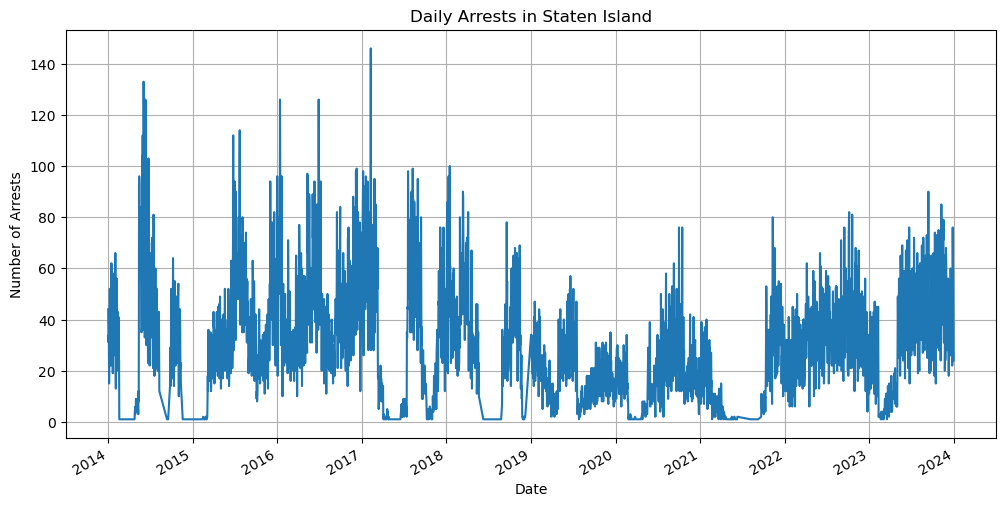

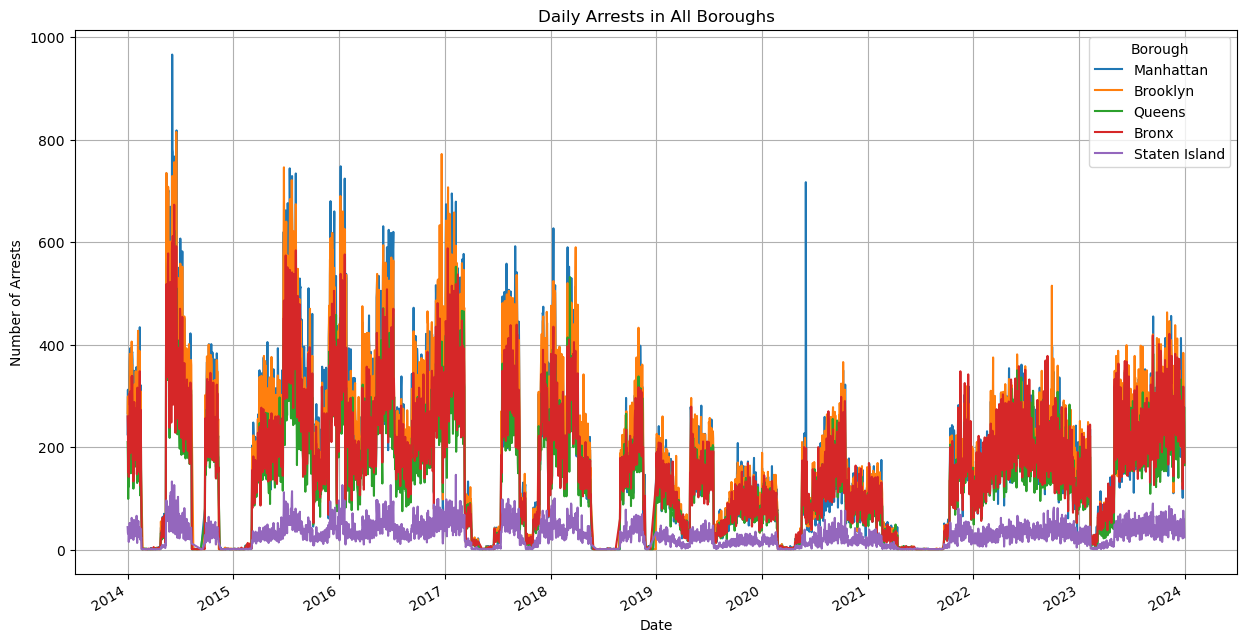

In [246]:
import matplotlib.pyplot as plt

# Define borough keys and labels for reference
borough_labels = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
borough_keys = ['M', 'K', 'Q', 'B', 'S']

# Plotting the data for each borough separately
for boro_key, boro_label in zip(borough_keys, borough_labels):
    # Filter data for the current borough
    borough_data = historical_df[historical_df['Arrest boro'] == boro_key]
    
    # Group by arrest_date and count the occurrences
    daily_counts = borough_data.groupby('Arrest date').size()
    
    # Plotting
    plt.figure(figsize=(12, 6))
    daily_counts.plot(title=f'Daily Arrests in {boro_label}')
    plt.xlabel('Date')
    plt.ylabel('Number of Arrests')
    plt.grid(True)
    plt.show()

# Combined plot for all boroughs
plt.figure(figsize=(15, 8))
for boro_key, boro_label in zip(borough_keys, borough_labels):
    # Filter data for the current borough
    borough_data = historical_df[historical_df['Arrest boro'] == boro_key]
    
    # Group by arrest_date and count the occurrences
    daily_counts = borough_data.groupby('Arrest date').size()
    
    # Plotting
    daily_counts.plot(kind='line', label=boro_label)

plt.title('Daily Arrests in All Boroughs')
plt.xlabel('Date')
plt.ylabel('Number of Arrests')
plt.legend(title='Borough')
plt.grid(True)
plt.show()

In [247]:
print(historical_df.columns)

Index(['Arrest date', 'Offense description', 'Arrest boro', 'Age group', 'Sex',
       'Race', 'Latitude', 'Longitude', 'lon_lat', 'year'],
      dtype='object')


In [248]:
# Step 1: Group by 'boro' and 'crime_type' and count occurrences
crime_counts = historical_df.groupby(['Arrest boro', 'Offense description']).size().reset_index(name='count')

sorted_crimes = crime_counts.sort_values(by=['Arrest boro', 'count'], ascending=[True, False])

most_common_crimes = sorted_crimes.groupby('Arrest boro').head()

print(most_common_crimes)


    Arrest boro              Offense description  count
8             B     ASSAULT 3 & RELATED OFFENSES  90996
17            B                  DANGEROUS DRUGS  84469
24            B                   FELONY ASSAULT  44189
67            B                    PETIT LARCENY  40247
78            B         VEHICLE AND TRAFFIC LAWS  32438
87            K     ASSAULT 3 & RELATED OFFENSES  87680
96            K                  DANGEROUS DRUGS  86319
104           K                   FELONY ASSAULT  48457
148           K                    PETIT LARCENY  47893
127           K          MISCELLANEOUS PENAL LAW  45743
178           M                  DANGEROUS DRUGS  88646
231           M                    PETIT LARCENY  82061
169           M     ASSAULT 3 & RELATED OFFENSES  62889
226           M  OTHER OFFENSES RELATED TO THEFT  43753
193           M                    GRAND LARCENY  39916
253           Q     ASSAULT 3 & RELATED OFFENSES  72931
262           Q                  DANGEROUS DRUGS

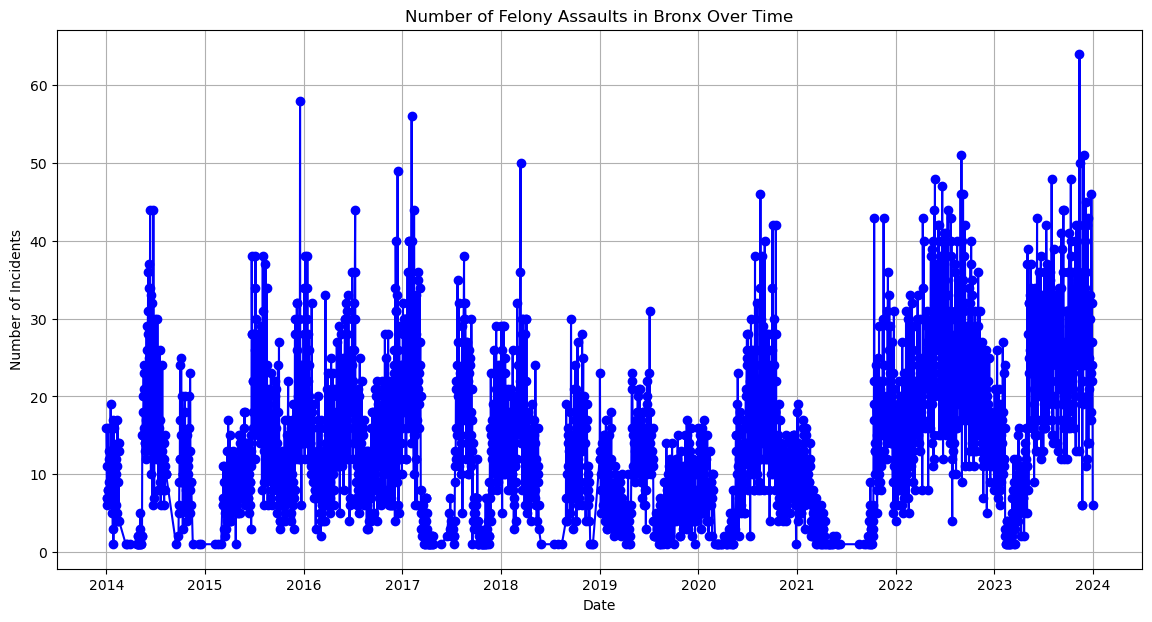

In [249]:
# Filter for 'FELONY ASSAULT' in the Bronx
felony_assault_bronx = historical_df[
    (historical_df['Offense description'] == 'FELONY ASSAULT') &
    (historical_df['Arrest boro'] == 'B')
]

# Group by date and count occurrences
date_counts = felony_assault_bronx.groupby('Arrest date').size()

# Plotting the data
plt.figure(figsize=(14, 7))  # Set the figure size for better visibility
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-', color='b')
plt.title('Number of Felony Assaults in Bronx Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)  # Adding a grid for better readability
plt.show()

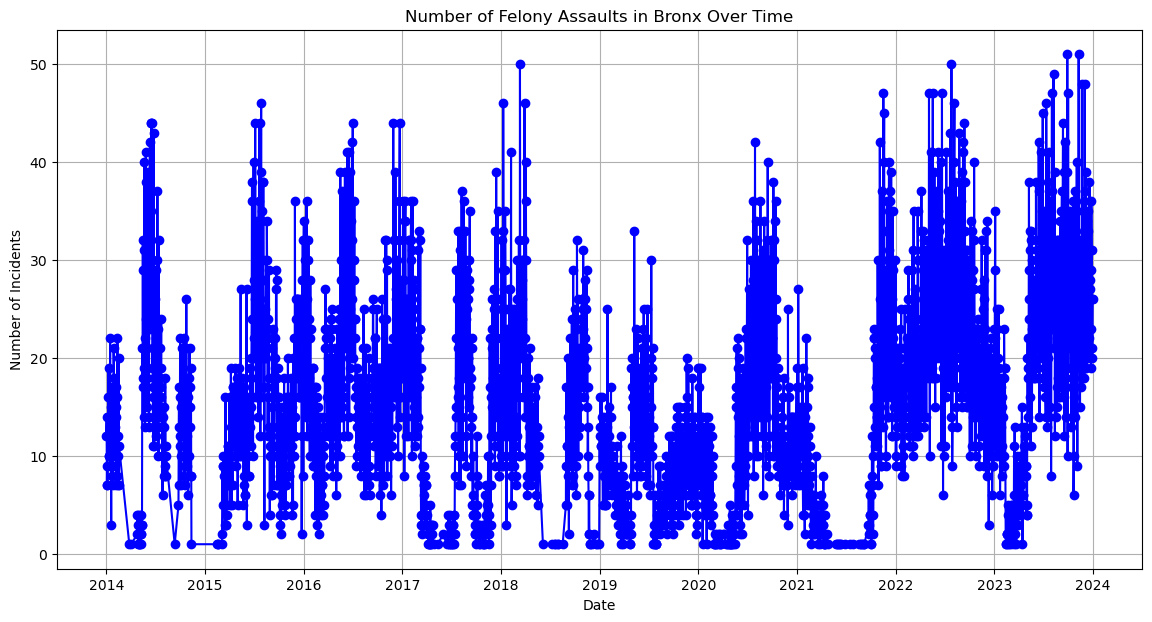

In [250]:
# Filter for 'FELONY ASSAULT' in the Queens
felony_assault_queens = historical_df[
    (historical_df['Offense description'] == 'FELONY ASSAULT') &
    (historical_df['Arrest boro'] == 'K')
]

# Group by date and count occurrences
date_counts = felony_assault_queens.groupby('Arrest date').size()

# Plotting the data
plt.figure(figsize=(14, 7))  # Set the figure size for better visibility
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-', color='b')
plt.title('Number of Felony Assaults in Bronx Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)  # Adding a grid for better readability
plt.show()

In [251]:
def showPieChart(data: pd.Series,date :str):
    plt.figure(figsize=(10, 6))
    data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of Offenses {date}')
    plt.ylabel('')  # Remove the y-label which shows the column name
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

def showChart(data: pd.Series,date :str):
    plt.figure(figsize=(10, 6))
    data.plot(kind='bar', color='red')
    plt.title(f'Top 5 {date} Offenses')
    plt.xlabel('Offense Description')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [252]:
offense_counts_2023 = historical_df['Offense description'].value_counts()
# Sort offenses by counts in descending order
sorted_offenses_2023 = offense_counts_2023.sort_values(ascending=False)
top_15_offenses_2023 = sorted_offenses_2023.head(15)
# Select the top 5 offenses 2023
top_5_offenses_2023 = sorted_offenses_2023.head(5)

In [253]:
# Set the base URL
base_url = "https://data.cityofnewyork.us/resource/uip8-fykc.json?"
# Set the query URL
query_url = base_url + "$limit=50000"
response = requests.get(query_url).json()
# Create a DataFrame
try:
    original_df = pd.DataFrame(response)
except : 
    print("Something went wrong...")
# Display original df
original_df

arrest_key              arrest_date pd_cd  \
0      280255493  2024-01-10T00:00:00.000   397   
1      279805419  2024-01-02T00:00:00.000   157   
2      279895750  2024-01-03T00:00:00.000   101   
3      280809090  2024-01-19T00:00:00.000   511   
4      280357135  2024-01-11T00:00:00.000   109   
...          ...                      ...   ...   
49995  283662436  2024-03-12T00:00:00.000   268   
49996  284068720  2024-03-20T00:00:00.000   105   
49997  283384015  2024-03-07T00:00:00.000   114   
49998  283729925  2024-03-14T00:00:00.000   101   
49999  283700123  2024-03-13T00:00:00.000   503   

                              pd_desc ky_cd                       ofns_desc  \
0      ROBBERY,OPEN AREA UNCLASSIFIED   105                         ROBBERY   
1                              RAPE 1   104                            RAPE   
2                           ASSAULT 3   344    ASSAULT 3 & RELATED OFFENSES   
3      CONTROLLED SUBSTANCE, POSSESSI   235                 DANGEROUS DRUGS   
4            ASSAULT 2,1,UNCLASSIFIED   106                  FELONY ASSAULT   
...                               ...   ...                             ...   
49995              CRIMINAL MIS 2 & 3   121  CRIMINAL MISCHIEF & RELATED OF   
49996               STRANGULATION 1ST   106                  FELONY ASSAULT   
49997             OBSTR BREATH/CIRCUL   344    ASSAULT 3 & RELATED OFFENSES   
49998                       ASSAULT 3   344    ASSAULT 3 & RELATED OFFENSES   
49999  CONTROLLED SUBSTANCE,INTENT TO   117                 DANGEROUS DRUGS   

         law_code law_cat_cd arrest_boro arrest_precinct  ... x_coord_cd  \
0      PL 1601001          F           M              26  ...     996342   
1      PL 1303501          F           K              77  ...    1003509   
2      PL 1200001          M           Q             106  ...    1026836   
3      PL 2200300          M           B              49  ...    1027430   
4      PL 1200502          F           K              81  ...    1002457   
...           ...        ...         ...             ...  ...        ...   
49995  PL 1450502          F           K              84  ...     988174   
49996  PL 1211300          F           M              25  ...    1002076   
49997  PL 121110A          M           M              28  ...     997373   
49998  PL 1200001          M           B              48  ...    1015629   
49999  PL 2201601          F           Q             102  ...    1030409   

      y_coord_cd            latitude           longitude  \
0         236149           40.814845          -73.956312   
1         185018    40.6744956865259   -73.9305713255961   
2         180689           40.662526          -73.846499   
3         251104           40.855793          -73.843908   
4         192292           40.694456          -73.934343   
...          ...                 ...                 ...   
49995     190975           40.690859          -73.985848   
49996     231440           40.801908          -73.935612   
49997     231879           40.803121          -73.952599   
49998     246174           40.842311          -73.886588   
49999     189906  40.687804468530956  -73.83356012817558   

                                         geocoded_column  \
0      {'type': 'Point', 'coordinates': [-73.956312, ...   
1      {'type': 'Point', 'coordinates': [-73.93057132...   
2      {'type': 'Point', 'coordinates': [-73.846499, ...   
3      {'type': 'Point', 'coordinates': [-73.843908, ...   
4      {'type': 'Point', 'coordinates': [-73.934343, ...   
...                                                  ...   
49995  {'type': 'Point', 'coordinates': [-73.985848, ...   
49996  {'type': 'Point', 'coordinates': [-73.935612, ...   
49997  {'type': 'Point', 'coordinates': [-73.952599, ...   
49998  {'type': 'Point', 'coordinates': [-73.886588, ...   
49999  {'type': 'Point', 'coordinates': [-73.83356012...   

      :@computed_region_f5dn_yrer :@computed_region_yeji_bk3q  \
0                       

In [254]:
original_df.drop(columns=['pd_cd','pd_desc','law_cat_cd','arrest_key','arrest_precinct','x_coord_cd', 'y_coord_cd', 'ky_cd',\
                           'jurisdiction_code', ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q',\
                            ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih', ':@computed_region_efsh_h5xi',\
                                'law_code'], inplace=True)

In [255]:
original_df.dropna(inplace=True)
original_df =original_df[original_df['ofns_desc'] != '(null)']

In [256]:
original_df.columns

Index(['arrest_date', 'ofns_desc', 'arrest_boro', 'age_group', 'perp_sex',
       'perp_race', 'latitude', 'longitude', 'geocoded_column'],
      dtype='object')

In [257]:
original_df.rename(columns=new_column_names,inplace=True)
original_df.columns

C:\Users\kidal\AppData\Local\Temp\ipykernel_15164\928729476.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Index(['Arrest date', 'Offense description', 'Arrest boro', 'Age group', 'Sex',
       'Race', 'Latitude', 'Longitude', 'geocoded_column'],
      dtype='object')

In [258]:
original_df

Arrest date             Offense description Arrest boro  \
0      2024-01-10T00:00:00.000                         ROBBERY           M   
1      2024-01-02T00:00:00.000                            RAPE           K   
2      2024-01-03T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           Q   
3      2024-01-19T00:00:00.000                 DANGEROUS DRUGS           B   
4      2024-01-11T00:00:00.000                  FELONY ASSAULT           K   
...                        ...                             ...         ...   
49995  2024-03-12T00:00:00.000  CRIMINAL MISCHIEF & RELATED OF           K   
49996  2024-03-20T00:00:00.000                  FELONY ASSAULT           M   
49997  2024-03-07T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           M   
49998  2024-03-14T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           B   
49999  2024-03-13T00:00:00.000                 DANGEROUS DRUGS           Q   

      Age group Sex            Race            Latitude           Longitude  \
0           <18   M           BLACK           40.814845          -73.956312   
1         25-44   M  WHITE HISPANIC    40.6744956865259   -73.9305713255961   
2           65+   F           WHITE           40.662526          -73.846499   
3         45-64   M           BLACK           40.855793          -73.843908   
4         25-44   F           BLACK           40.694456          -73.934343   
...         ...  ..             ...                 ...                 ...   
49995       65+   F           BLACK           40.690859          -73.985848   
49996     25-44   M  BLACK HISPANIC           40.801908          -73.935612   
49997     25-44   M           BLACK           40.803121          -73.952599   
49998     25-44   F  WHITE HISPANIC           40.842311          -73.886588   
49999     25-44   M  WHITE HISPANIC  40.687804468530956  -73.83356012817558   

                                         geocoded_column  
0      {'type': 'Point', 'coordinates': [-73.956312, ...  
1      {'type': 'Point', 'coordinates': [-73.93057132...  
2      {'type': 'Point', 'coordinates': [-73.846499, ...  
3      {'type': 'Point', 'coordinates': [-73.843908, ...  
4      {'type': 'Point', 'coordinates': [-73.934343, ...  
...                                                  ...  
49995  {'type': 'Point', 'coordinates': [-73.985848, ...  
49996  {'type': 'Point', 'coordinates': [-73.935612, ...  
49997  {'type': 'Point', 'coordinates': [-73.952599, ...  
49998  {'type': 'Point', 'coordinates': [-73.886588, ...  
49999  {'type': 'Point', 'coordinates': [-73.83356012...  

[49993 rows x 9 columns]

In [259]:
pd.set_option('display.max_rows', 200)

In [260]:
original_df['Offense description'].value_counts()

Offense description
ASSAULT 3 & RELATED OFFENSES            6940
PETIT LARCENY                           5048
FELONY ASSAULT                          4079
DANGEROUS DRUGS                         3787
VEHICLE AND TRAFFIC LAWS                3183
MISCELLANEOUS PENAL LAW                 3148
GRAND LARCENY                           2431
ROBBERY                                 2358
CRIMINAL MISCHIEF & RELATED OF          2243
DANGEROUS WEAPONS                       1951
OTHER OFFENSES RELATED TO THEF          1765
OFFENSES AGAINST PUBLIC ADMINI          1538
BURGLARY                                1249
OFFENSES INVOLVING FRAUD                1103
SEX CRIMES                              1070
FORGERY                                 1009
OFF. AGNST PUB ORD SENSBLTY &            880
POSSESSION OF STOLEN PROPERTY            861
CRIMINAL TRESPASS                        607
OTHER TRAFFIC INFRACTION                 596
INTOXICATED & IMPAIRED DRIVING           505
GRAND LARCENY OF MOTOR VEHICLE     

In [261]:
offense_counts_2024 = original_df['Offense description'].value_counts()
# Sort offenses by counts in descending order
sorted_offenses_2024 = offense_counts_2024.sort_values(ascending=False)
top_15_offenses_2024 = sorted_offenses_2024.head(15)
# Select the top 5 offenses 2024
top_5_offenses_2024 = sorted_offenses_2024.head(5)

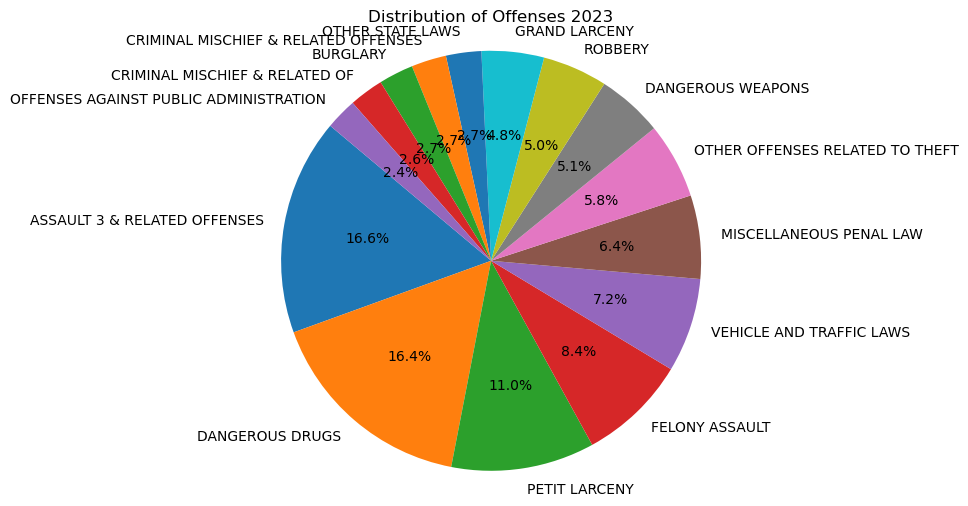

In [262]:
# Plot the top 15 offenses2023
showPieChart(top_15_offenses_2023,"2023")

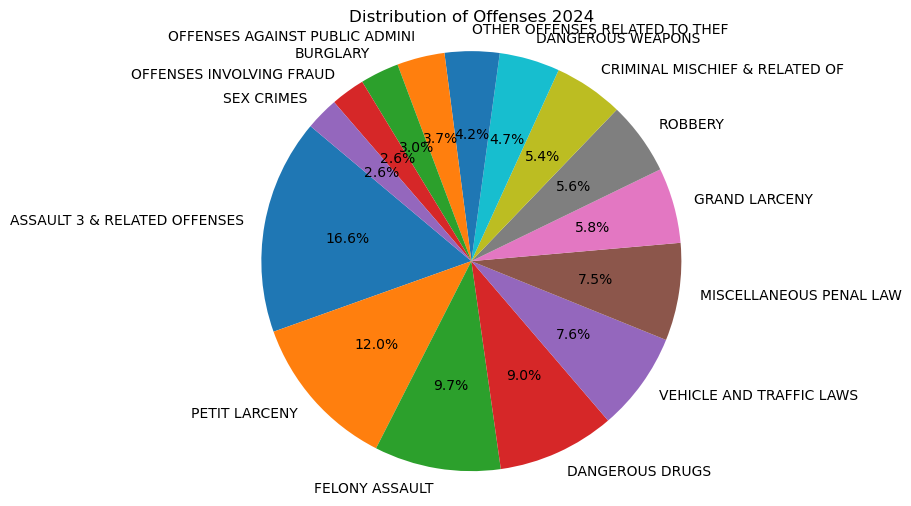

In [263]:
# Plot the top 15 offenses 2024
showPieChart(top_15_offenses_2024,"2024")

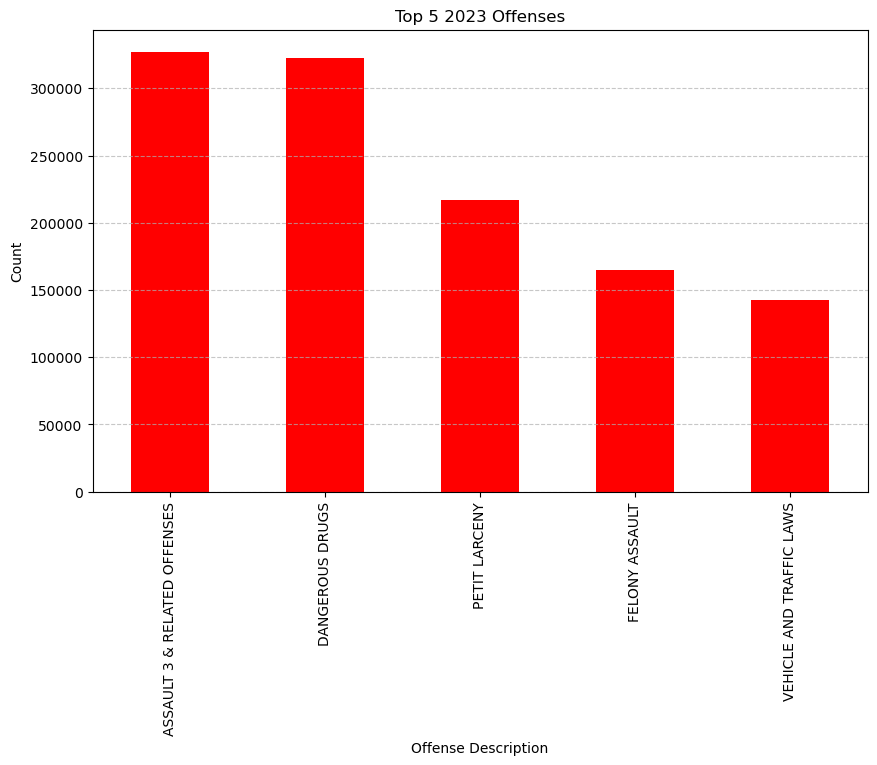

In [264]:
# Plot the top 5 offenses 2023
showChart(top_5_offenses_2023,"2023")

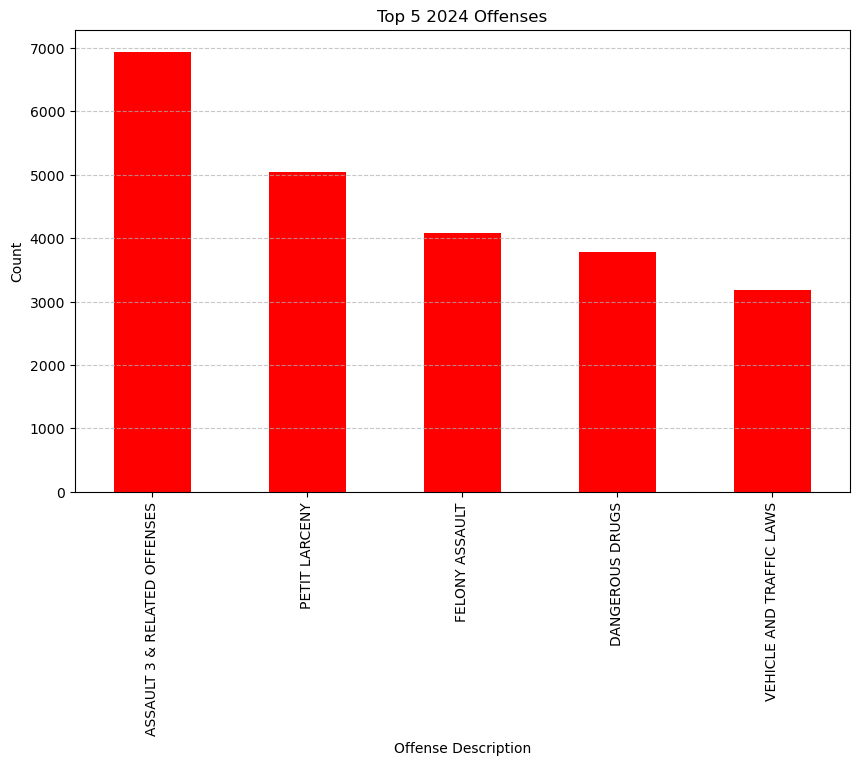

In [265]:
# Plot the top 5 offenses 2024
showChart(top_5_offenses_2024,"2024")

In [266]:
import plotly.express as px
# converint coordinates to numeric
original_df['Latitude'] = pd.to_numeric(original_df['Latitude'], errors='coerce')
original_df['Longitude'] = pd.to_numeric(original_df['Longitude'], errors='coerce')
fig = px.scatter_mapbox(original_df, lat='Latitude', lon='Longitude', color='Arrest date',
                        mapbox_style='carto-positron', zoom=10, opacity=0.5,
                        center={'lat': original_df['Latitude'].mean(), 'lon': original_df['Longitude'].mean()},
                        title='Crime dates per borough 2024')

# Ensure markers are shown
fig.update_traces(mode='markers', marker=dict(size=10))
# Show the figure
fig.show()

C:\Users\kidal\AppData\Local\Temp\ipykernel_15164\972572206.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\kidal\AppData\Local\Temp\ipykernel_15164\972572206.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [267]:
fig = px.scatter_mapbox(original_df, lat='Latitude', lon='Longitude', color='Offense description',
                        mapbox_style='carto-positron', zoom=10, opacity=0.5,
                        center={'lat': original_df['Latitude'].mean(), 'lon': original_df['Longitude'].mean()},
                        title='Offenses per borough 2024')

# Ensure markers are shown
fig.update_traces(mode='markers', marker=dict(size=10))
# Show the figure
fig.show()

In [268]:
fig = px.scatter_mapbox(original_df, lat='Latitude', lon='Longitude', color='Arrest boro',
                        mapbox_style='carto-positron', zoom=10, opacity=0.5,
                        center={'lat': original_df['Latitude'].mean(), 'lon': original_df['Longitude'].mean()},
                        title='Boroughs with arrests 2024')

# Ensure markers are shown
fig.update_traces(mode='markers', marker=dict(size=10))
# Show the figure
fig.show()

In [269]:
grouped_by_boro_2024=original_df.groupby('Arrest boro')[['Arrest date']].count()
grouped_by_boro_2024

Arrest date
Arrest boro             
B                  11226
K                  13608
M                  12022
Q                  10878
S                   2259

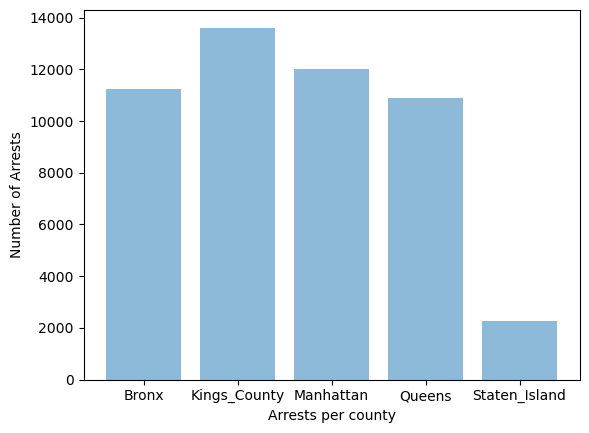

In [270]:
boroughs= ['Bronx','Kings_County', 'Manhattan', 'Queens', 'Staten_Island']
arrest=[11227, 13612, 12024, 10878, 2259]
x_axis = np.arange(len(arrest))
plt.bar(x_axis, arrest, align='center', alpha=0.5)
plt.xticks(x_axis, boroughs)
plt.ylabel('Number of Arrests')
plt.xlabel('Arrests per county')
plt.show()

In [271]:
race_counts_2024 = original_df['Race'].value_counts()
# Sort offenses by counts in descending order
race_counts_2024_sorted = race_counts_2024.sort_values(ascending=False)
race_counts_2024_adjusted = race_counts_2024_sorted.head(len(race_counts_2023_sorted))

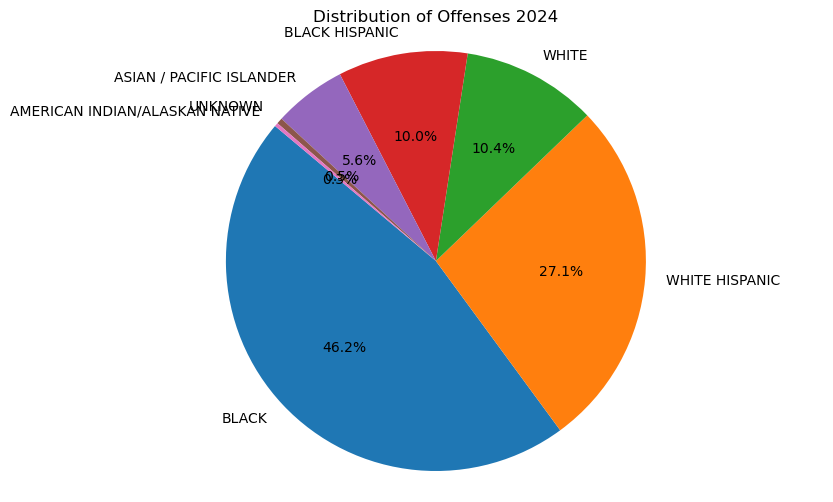

In [272]:
# Show plot fitrst 3 month of 2024 by race
showPieChart(race_counts_2024,"2024")

In [273]:
age_counts_2024 = original_df['Age group'].value_counts()
# Sort offenses by counts in descending order
age_counts_2024_sorted = age_counts_2024.sort_values(ascending=False)

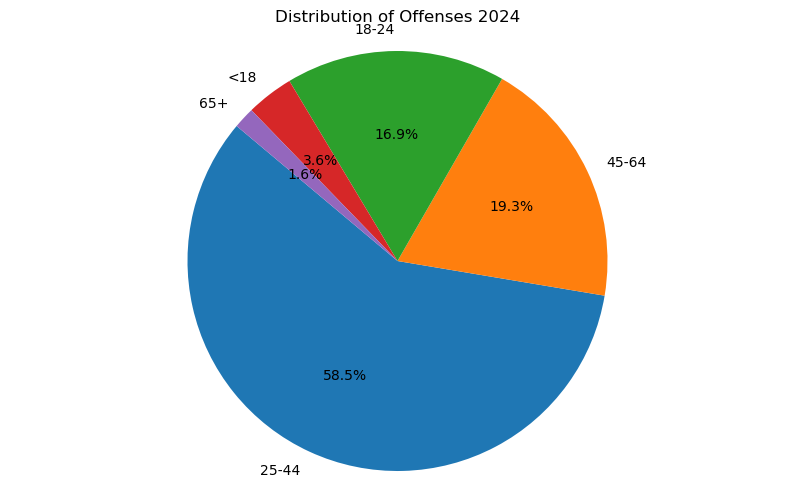

In [274]:
# Show plot fitrst 3 month of 2024 by age
showPieChart(age_counts_2024_sorted,"2024")

In [275]:
c = pd.read_csv("./final_census_df.csv")
c.head()

zip_code  population  poverty_rate  median_income
0       601       17242     62.475351          13092
1       602       38442     51.014515          16358
2       603       48814     49.856599          16603
3       606        6437     64.672984          12832
4       610       27073     43.305138          19309

In [276]:
df_sex_age_borough=original_df.groupby(['Arrest boro' ,'Sex', 'Age group'])[['Arrest date']].count()
df_sex_age_borough

Arrest date
Arrest boro Sex Age group             
B           F   18-24              346
                25-44             1127
                45-64              319
                65+                 20
                <18                 89
            M   18-24             1724
                25-44             5540
                45-64             1622
                65+                131
                <18                308
K           F   18-24              394
                25-44             1383
                45-64              439
                65+                 25
                <18                 91
            M   18-24             1858
                25-44             6470
                45-64             2292
                65+                180
                <18                476
M           F   18-24              392
                25-44             1332
                45-64              334
                65+                 25
                <18                 69
            M   18-24             1464
                25-44             5712
                45-64             2195
                65+                172
                <18                327
Q           F   18-24              332
                25-44             1079
                45-64              351
                65+                 37
                <18                 55
            M   18-24             1577
                25-44             5255
                45-64             1680
                65+                177
                <18                335
S           F   18-24               85
                25-44              263
                45-64               77
                65+                 10
                <18                 19
            M   18-24              280
                25-44             1070
                45-64              361
                65+                 44
                <18                 50

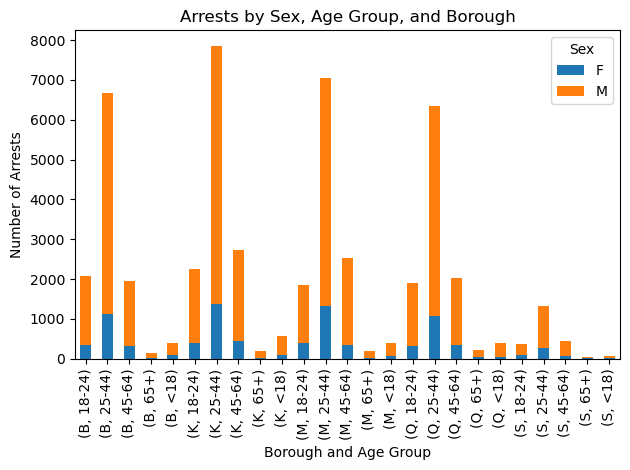

In [277]:
df_sex_age_borough_reset = df_sex_age_borough.reset_index()
pivot_df = df_sex_age_borough_reset.pivot_table(index=['Arrest boro', 'Age group'], columns='Sex', values='Arrest date')
pivot_df.plot(kind='bar', stacked=True)
plt.xlabel('Borough and Age Group')
plt.ylabel('Number of Arrests')
plt.title('Arrests by Sex, Age Group, and Borough')
plt.xticks(rotation=90)
plt.legend(title='Sex')
plt.tight_layout()
plt.show()

